# Введение. Постановка целей и задач


Текущая пандемия SARS-Cov-2 достигла Австралии в январе 2020 года. Первый случай был зафиксирован 25.01.2020 года в штате Виргиния у человека, вернувшегося из города Ухань.
Провительством был сформирован национальный кризисный кабинет впервые со Второй Мировой войны.

Цель данной работы: анализ и прогнозирование распространения COVID-19 в Австралии.

Задачи:
- исследование данных о пандемии;
- построение модели для прогнозирования распространения заболевания на контененте.

#Импорт Датафрейма, библиотек

## Импорт библиотек

In [3]:
# Загружаем pmdarima

!pip install pmdarima

     |████████████████████████████████| 1.4 MB 4.0 MB/s 
     |████████████████████████████████| 9.8 MB 48.7 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [4]:
# Загружаем pmdarima

!pip install pmdarima

In [5]:
## Импортируем необходимые библиотеки и функции

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# импорт моделей 
from statsmodels.tsa.statespace.sarimax import SARIMAX       # для модели SARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # для графиков автокорреляции и частичной автокорреляции
from statsmodels.tsa.seasonal import seasonal_decompose      # для ETS графиков
from statsmodels.tsa.stattools import adfuller               # для теста Дики-Фуллера
from statsmodels.tsa.holtwinters import ExponentialSmoothing # для модели Хольта-Винтерса
from pmdarima import auto_arima                              # для поиска ARIMA моделей
from fbprophet import Prophet                                # для модели Prophet

# метрики
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_error

# для игнорирования предупреждений
import warnings
warnings.filterwarnings("ignore")

## Загрузка и знакомство с датафреймом

In [6]:
# Загружаем датафрейм через ссылку
url = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv'
df = pd.read_csv(url)
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [7]:
# Смотрим структуру и тип данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149880 entries, 0 to 149879
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    149880 non-null  object 
 1   continent                                   140834 non-null  object 
 2   location                                    149880 non-null  object 
 3   date                                        149880 non-null  object 
 4   total_cases                                 147259 non-null  float64
 5   new_cases                                   147253 non-null  float64
 6   new_cases_smoothed                          146108 non-null  float64
 7   total_deaths                                130199 non-null  float64
 8   new_deaths                                  130394 non-null  float64
 9   new_deaths_smoothed                         146108 non-null  float64
 

Выделим те показатели которые предположительно позволят нам, построить точный прогноз:


- date - дата наблюдения;
- location - географическое положение (страна);
- total_cases - всего подтвержденных случаев COVID-19;
- new_cases - новые подтвержденные случаи COVID-19
- total_deaths - общее количество смертей, связанных с COVID-19;
- new_deaths - новые случаи смерти, связанные с COVID-19;
- total_vaccinatins - общее количество тестов на COVID-19;
- new_vaccinations - общее количество введенных доз вакцины против COVID-19.

In [8]:
# Выведем список всех стран, по которым представлены данные о COVID-19
df.location.unique()

array(['Afghanistan', 'Africa', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Asia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Cook Islands',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao',
       'Cyprus', 'Czechia', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethi

#Предобработка данных

##Фильтрация данных

In [89]:
# Необходимо паредставить данные по Австралии
df_a = df[df.location == 'Australia'][['date','total_cases', 'new_cases', 'total_deaths', 'new_deaths', 'total_vaccinations', 'new_vaccinations']]
df

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149875,ZWE,Africa,Zimbabwe,2021-12-21,197768.0,2689.0,3679.429,4819.0,14.0,11.286,13104.013,178.172,243.797,319.305,0.928,0.748,1.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12086.0,1657381.0,109.817,0.801,8597.0,0.570,0.4280,2.3,tests performed,7151946.0,4069302.0,3082644.0,NaN,16933.0,24507.0,47.39,26.96,20.43,NaN,1624.0,12505.0,0.083,NaN,15092171.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
149876,ZWE,Africa,Zimbabwe,2021-12-22,199404.0,1636.0,3102.000,4828.0,9.0,11.857,13212.413,108.401,205.537,319.901,0.596,0.786,1.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4663.0,1662044.0,110.126,0.309,7451.0,0.494,0.4163,2.4,tests performed,7167610.0,4078945.0,3088665.0,Na

In [11]:
# Вносим изменеия в тип данных по дате и проверяем
df_a['date'] = pd.to_datetime(df_a['date'])
df_a.dtypes

date                  datetime64[ns]
total_cases                  float64
new_cases                    float64
total_deaths                 float64
new_deaths                   float64
total_vaccinations           float64
new_vaccinations             float64
dtype: object

##Обработка пропусков


Так как пропуски (NaN) находятся из-за недоступности данных на определенный день, можно считать в такие дни, что показатель = 0.

In [12]:
# Проверяем данные на наличие пропусков 
print('Общее количество пропусков:', df_a.isna().sum().sum())
df_a.isna()

Общее количество пропусков: 867


,date,total_cases,new_cases,total_deaths,new_deaths,total_vaccinations,new_vaccinations
8040,False,False,False,True,True,True,True
8041,False,False,False,True,True,True,True
8042,False,False,False,True,True,True,True
8043,False,False,False,True,True,True,True
8044,False,False,False,True,True,True,True
...,...,...,...,...,...,...,...
8735,False,False,False,False,False,False,False
8736,False,False,False,False,False,False,False
8737,False,False,False,False,False,False,False
8738,False,False,False,False,False,False,False


In [13]:
df_check = df_a.isna()

for i in df_check.columns:
    print(f'Для признака {i} пропуски: ', df_check[i].unique())

Для признака date пропуски:  [False]
Для признака total_cases пропуски:  [False]
Для признака new_cases пропуски:  [False]
Для признака total_deaths пропуски:  [ True False]
Для признака new_deaths пропуски:  [ True False]
Для признака total_vaccinations пропуски:  [ True False]
Для признака new_vaccinations пропуски:  [ True False]


In [14]:
# Удоляем пропуска заменяя их на ноль
df_a = df_a.fillna(0)
print('Общее количество пропусков:', df_a.isna().sum().sum())

Общее количество пропусков: 0


Вывод по блоку. В данном блоке мы осуществили фильтрацию данных, а именно выбрали данные по Австралии и необходимые признаки в новый датасет. Установили, что наши данные содержали пропуски, которые возникли по причине добавления наблюдения ряда признаков спустя продолжительное время после первого случая заболевания в стране (данные по смертям от COVID-19, тестированию и вакцинации), подготовили данные для дальнейшего исследования.

# Разведочный анализ данных


На данном этапе проведем иследование даинамики и структуры следующих показателей:
- total vaccination
- new cases
- new deaths

## EDA

In [15]:
# Индексируем датасет  по дате
df_a.index = df_a.date
df_a.tail()

,date,total_cases,new_cases,total_deaths,new_deaths,total_vaccinations,new_vaccinations
date,,,,,,,
2021-12-21,2021-12-21,264705.0,5531.0,2162.0,8.0,41652458.0,206796.0
2021-12-22,2021-12-22,273062.0,8357.0,2173.0,11.0,41867748.0,215290.0
2021-12-23,2021-12-23,281280.0,8218.0,2182.0,9.0,42060100.0,192352.0
2021-12-24,2021-12-24,291135.0,9855.0,2188.0,6.0,42060100.0,0.0
2021-12-25,2021-12-25,300594.0,9459.0,2190.0,2.0,42060100.0,0.0


Визуализируем выбранным показателям

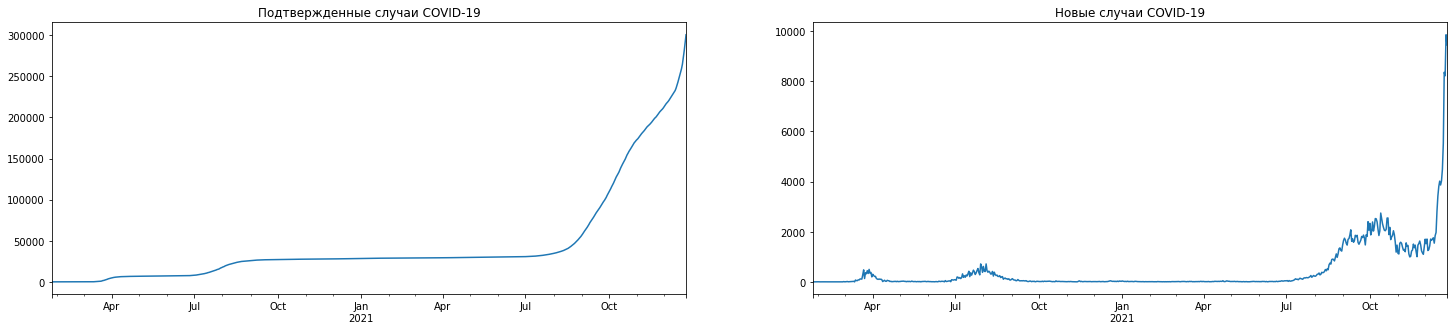

In [16]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25,5))
df_a['total_cases'].plot(ax=ax1, title='Подтвержденные случаи COVID-19', xlabel='').ticklabel_format(axis='y', style='plain')
df_a['new_cases'].plot(ax=ax2, title='Новые случаи COVID-19', xlabel='').ticklabel_format(axis='y', style='plain')



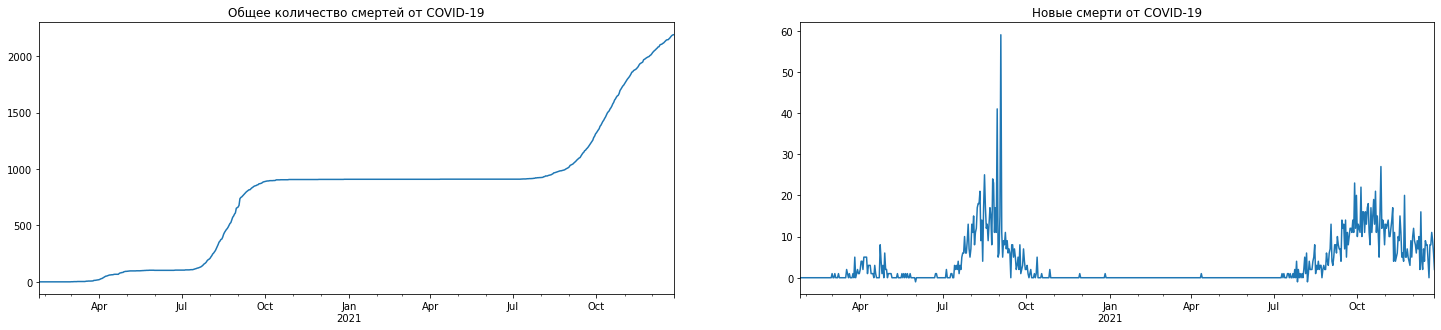

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25,5))
df_a['total_deaths'].plot(ax=ax1, title='Общее количество смертей от COVID-19', xlabel='').ticklabel_format(axis='y', style='plain')
df_a['new_deaths'].plot(ax=ax2, title='Новые смерти от COVID-19', xlabel='').ticklabel_format(axis='y', style='plain')

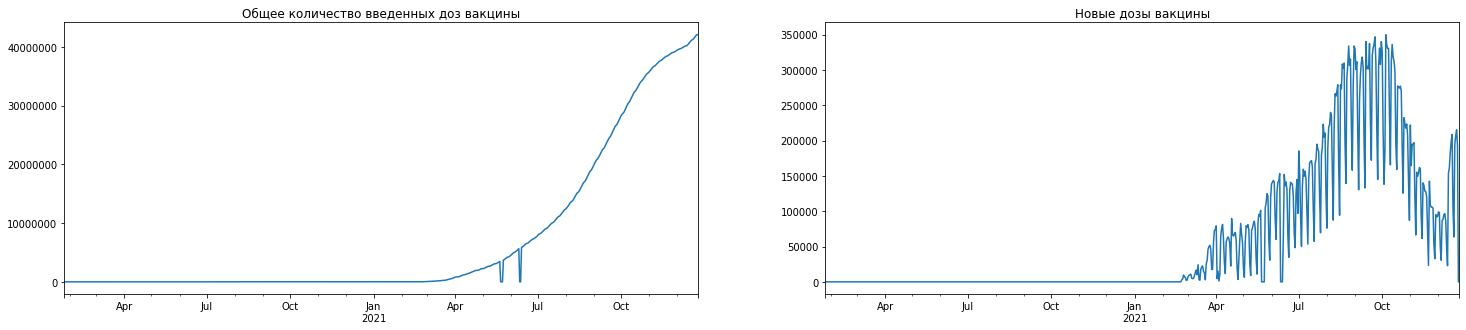

In [18]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25,5))
df_a['total_vaccinations'].plot(ax=ax1, title='Общее количество введенных доз вакцины', xlabel='').ticklabel_format(axis='y', style='plain')
df_a['new_vaccinations'].plot(ax=ax2, title='Новые дозы вакцины', xlabel='').ticklabel_format(axis='y', style='plain')


In [19]:
df_a.corr().round(2)

,total_cases,new_cases,total_deaths,new_deaths,total_vaccinations,new_vaccinations
total_cases,1.00,0.80,0.86,0.46,0.94,0.50
new_cases,0.80,1.00,0.59,0.44,0.78,0.53
total_deaths,0.86,0.59,1.00,0.32,0.79,0.53
new_deaths,0.46,0.44,0.32,1.00,0.49,0.39
total_vaccinations,0.94,0.78,0.79,0.49,1.00,0.71
new_vaccinations,0.50,0.53,0.53,0.39,0.71,1.00


Наблюдаем высокую степень корреляции в парах:
- total_vaccinations/total_cases - 0.94
- total_vactinationa/total_deaths - 0.79

Также обратим ванимание, что вакцинация населения начилась позже первой вспышки заболеваемости и смеретей от COVID-19



In [20]:
#Создадим новый датафрейм с данными начиная с марта 2021 года так как с этого момента начилась активная вакцинация население
df_a2= df_a.loc['2021-03-01':]

In [21]:
df_a2.tail()

,date,total_cases,new_cases,total_deaths,new_deaths,total_vaccinations,new_vaccinations
date,,,,,,,
2021-12-21,2021-12-21,264705.0,5531.0,2162.0,8.0,41652458.0,206796.0
2021-12-22,2021-12-22,273062.0,8357.0,2173.0,11.0,41867748.0,215290.0
2021-12-23,2021-12-23,281280.0,8218.0,2182.0,9.0,42060100.0,192352.0
2021-12-24,2021-12-24,291135.0,9855.0,2188.0,6.0,42060100.0,0.0
2021-12-25,2021-12-25,300594.0,9459.0,2190.0,2.0,42060100.0,0.0


In [22]:
df_a2.corr().round(2)

,total_cases,new_cases,total_deaths,new_deaths,total_vaccinations,new_vaccinations
total_cases,1.00,0.77,1.00,0.64,0.93,0.18
new_cases,0.77,1.00,0.71,0.57,0.74,0.36
total_deaths,1.00,0.71,1.00,0.62,0.92,0.14
new_deaths,0.64,0.57,0.62,1.00,0.76,0.57
total_vaccinations,0.93,0.74,0.92,0.76,1.00,0.45
new_vaccinations,0.18,0.36,0.14,0.57,0.45,1.00


Корреляция в паре total_vaccination/new_deaths возрасла с 0.50 до 0.77.

In [23]:
df[['total_vaccinations', 'new_cases','new_deaths']].describe().round()

,total_vaccinations,new_cases,new_deaths
count,3.777100e+04,147253.0,130394.0
mean,1.329977e+08,7939.0,172.0
std,6.113512e+08,43387.0,836.0
min,0.000000e+00,-74347.0,-1918.0
25%,4.668120e+05,1.0,0.0
50%,3.574210e+06,67.0,2.0
75%,2.178378e+07,903.0,19.0
max,8.956163e+09,971581.0,18062.0


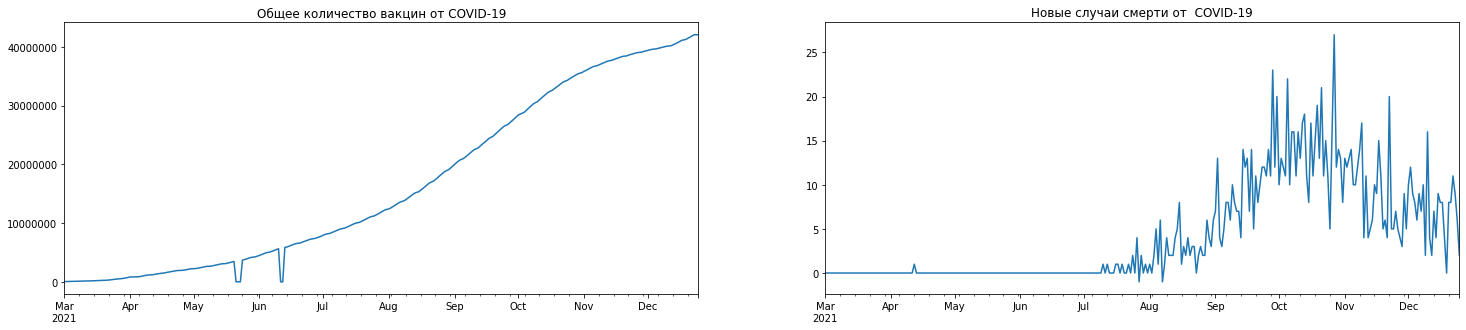

In [24]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25,5))
df_a2['total_vaccinations'].plot(ax=ax1, title='Общее количество вакцин от COVID-19', xlabel='').ticklabel_format(axis='y', style='plain')
df_a2['new_deaths'].plot(ax=ax2, title='Новые случаи смерти от  COVID-19', xlabel='').ticklabel_format(axis='y', style='plain')

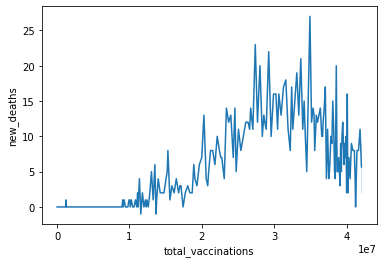

In [25]:
sns.lineplot(data = df_a2, x = 'total_vaccinations', y = 'new_deaths')

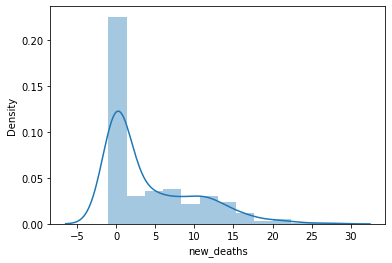

In [26]:
sns.distplot(df_a2.new_deaths)

##Проверка ряда на стационарность

Тест Дики -Фуллера

In [27]:
adfuller(df_a2.total_vaccinations)

(2.040847420722741,
 0.9987237335632573,
 4,
 295,
 {'1%': -3.452713099849546,
  '10%': -2.5720171933352485,
  '5%': -2.871387839457783},
 8281.857053233853)

In [28]:
adfuller(df_a2.new_deaths)

(-1.1626847831455192,
 0.6894383757714562,
 16,
 283,
 {'1%': -3.453670163592738,
  '10%': -2.5722411158835796,
  '5%': -2.8718077069772248},
 1378.490097680582)

Представленные ряды не являются стационарными так как их свойства со изсменяются 

##Построение графиков автокорреляции и частичной автокорреляции

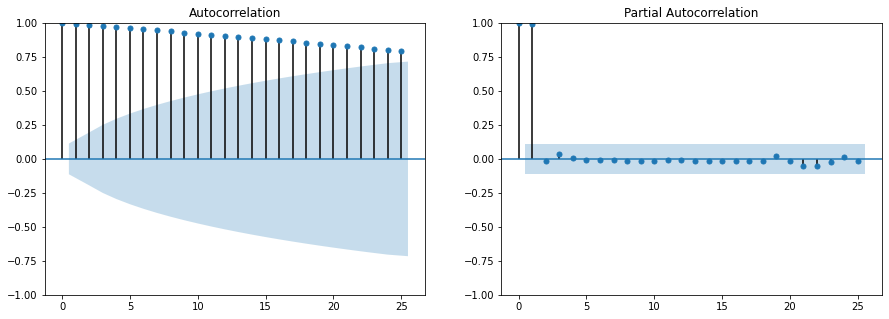

In [29]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

plot_acf(df_a2.total_vaccinations, ax=ax1);
plot_pacf(df_a2.total_vaccinations, ax=ax2);

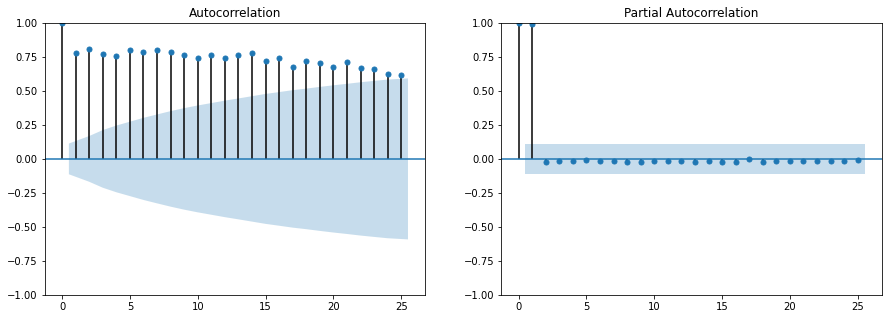

In [30]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

plot_acf(df_a2.new_deaths, ax=ax1);
plot_pacf(df_a2.total_deaths, ax=ax2);

## ETL композиция

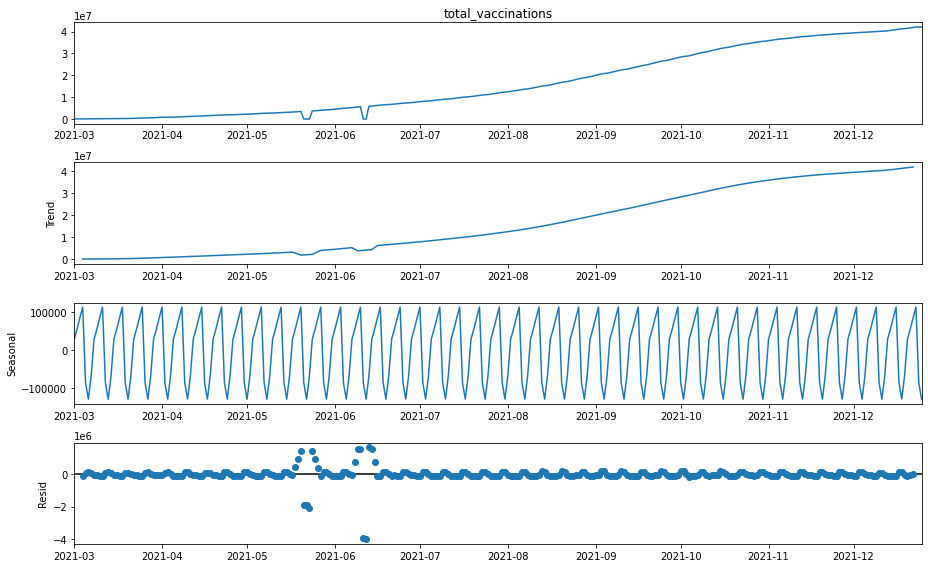

In [31]:
plt.rcParams['figure.figsize'] = (13, 8)
r = seasonal_decompose(df_a2['total_vaccinations'],model='additive')
r.plot();

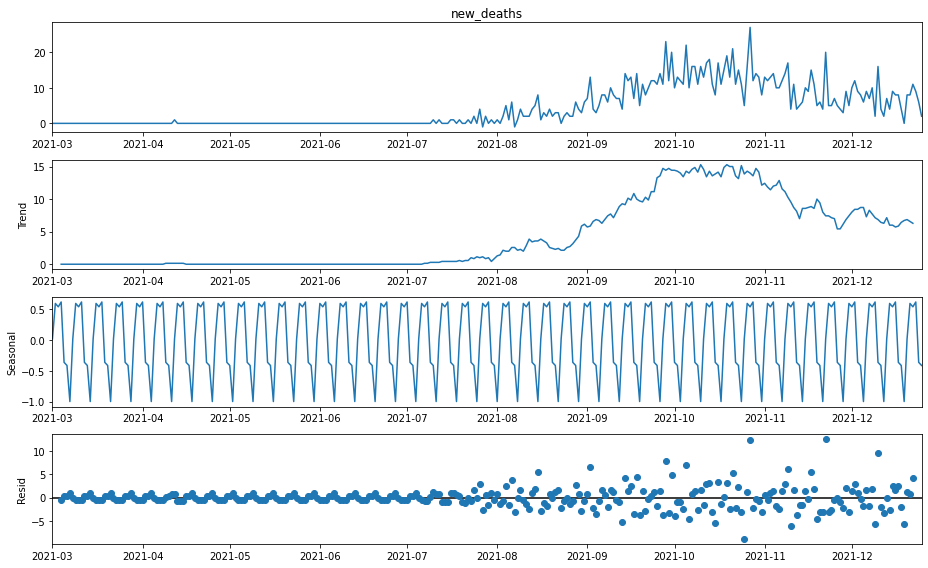

In [32]:
plt.rcParams['figure.figsize'] = (13, 8)
r = seasonal_decompose(df_a2['new_deaths'],model='additive')
r.plot();

Недельная сезонность в new deaths предположительно связана с порядком фиксации новых случаев смерти от COVID-19

#Построение моделей

## Разделение датасета на тренирвочную и тестовую выборки
 

Тестовую выборку определяем в 10 последних наблюдений

In [33]:
train = df_a2.iloc[:len(df_a2)-10]
test = df_a2.iloc[len(df_a2)-10:]

In [34]:
train.tail()

,date,total_cases,new_cases,total_deaths,new_deaths,total_vaccinations,new_vaccinations
date,,,,,,,
2021-12-11,2021-12-11,228925.0,1543.0,2104.0,4.0,40154757.0,49260.0
2021-12-12,2021-12-12,230768.0,1843.0,2106.0,2.0,40177641.0,22884.0
2021-12-13,2021-12-13,232738.0,1970.0,2113.0,7.0,40331164.0,153523.0
2021-12-14,2021-12-14,235547.0,2809.0,2117.0,4.0,40492691.0,161527.0
2021-12-15,2021-12-15,238970.0,3423.0,2126.0,9.0,40675738.0,183047.0


In [35]:
test.tail()

,date,total_cases,new_cases,total_deaths,new_deaths,total_vaccinations,new_vaccinations
date,,,,,,,
2021-12-21,2021-12-21,264705.0,5531.0,2162.0,8.0,41652458.0,206796.0
2021-12-22,2021-12-22,273062.0,8357.0,2173.0,11.0,41867748.0,215290.0
2021-12-23,2021-12-23,281280.0,8218.0,2182.0,9.0,42060100.0,192352.0
2021-12-24,2021-12-24,291135.0,9855.0,2188.0,6.0,42060100.0,0.0
2021-12-25,2021-12-25,300594.0,9459.0,2190.0,2.0,42060100.0,0.0


##SARIMA

Исспользуем функцию auto_arima которая на основании временного ряда подберет оптимальную модель. Для учета сезонности внесем соответствующие параметры и получим модель SARIMA.

In [36]:
auto_arima(df_a2['new_deaths'],seasonal=True, m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  300
Model:             SARIMAX(1, 1, 1)x(2, 0, 1, 7)   Log Likelihood                -714.887
Date:                           Sun, 26 Dec 2021   AIC                           1441.775
Time:                                   10:26:08   BIC                           1463.978
Sample:                                        0   HQIC                          1450.661
                                           - 300                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1369      0.052     -2.633      0.008      -0.239      -0.035
ma.L1         -0.8324      0.026    -31.627      0.000      -0.884      -0.781
ar.S.L7        0.5651      0.117      4.817      0.000       0.335       0.795
ar.S.L14       0.1729      0.046      3.795      0.000       0.084       0.262
ma.S.L7       -0.4629      0.116     -3.999      0.000      -0.690      -0.236
sigma2         6.9198      0.288     24.046      0.000       6.356       7.484
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               512.73
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):            1423.99   Skew:                             0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Обучим модель используя параметры  SARIMAX (1,1,1)x(2,0,1,7)

In [37]:
model_sarima = SARIMAX(train['new_deaths'],order=(1, 1, 1),seasonal_order=(2, 0, 1, 7))
results_sarima = model_sarima.fit()
results_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                        new_deaths   No. Observations:                  290
Model:             SARIMAX(1, 1, 1)x(2, 0, 1, 7)   Log Likelihood                -688.930
Date:                           Sun, 26 Dec 2021   AIC                           1389.859
Time:                                   10:26:09   BIC                           1411.858
Sample:                               03-01-2021   HQIC                          1398.674
                                    - 12-15-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1635      0.053     -3.111      0.002      -0.267      -0.061
ma.L1         -0.8225      0.027    -29.911      0.000      -0.876      -0.769
ar.S.L7        0.4426      0.131      3.379      0.001       0.186       0.699
ar.S.L14       0.2062      0.042      4.879      0.000       0.123       0.289
ma.S.L7       -0.3597      0.127     -2.829      0.005      -0.609      -0.110
sigma2         6.8255      0.282     24.231      0.000       6.273       7.378
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               564.18
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):            1396.87   Skew:                             0.75
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Посмотрим результаты обучения модели

In [38]:
start=len(train)
end=len(train)+len(test)-1
predictions_sarima = results_sarima.predict(start=start, end=end, dynamic=False, typ='levels').rename('Predictions SARIMA(1, 1, 1)x(2, 0, 1, 7)')

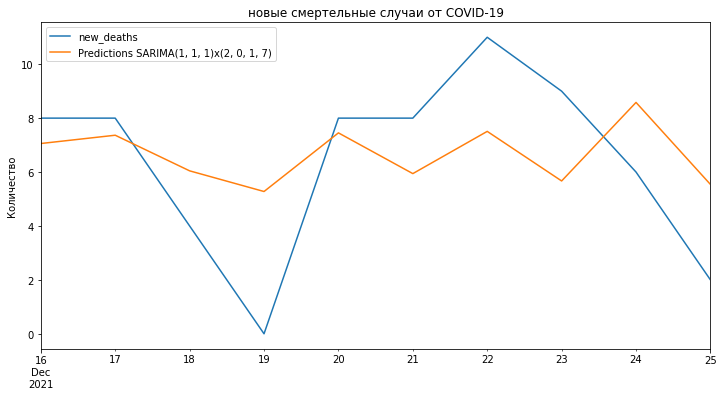

In [39]:

test['new_deaths'].plot(title = 'новые смертельные случаи от COVID-19', xlabel = '', ylabel = 'Количество', legend=True,  figsize=(12,6))
predictions_sarima.plot(legend=True);

Оценим качество модели с помощью MSE и RMSE

In [84]:

mse_error = mean_squared_error(test['new_deaths'], predictions_sarima)
rmse_error = rmse(test['new_deaths'], predictions_sarima)


print(f'SARIMAX(2, 1, 1)x(1, 0, 1, 7) MSE Error: {mse_error:11.10}')
print(f'SARIMAX(2, 1, 1)x(1, 0, 1, 7) RMSE Error: {rmse_error:11.10}')

SARIMAX(2, 1, 1)x(1, 0, 1, 7) MSE Error:  8.03559286
SARIMAX(2, 1, 1)x(1, 0, 1, 7) RMSE Error:  2.83471213


Мы не смогли вычеслить MAPE Error так как присутствуют нулевые значения

Запускаем модель на полном датасете

In [41]:

fut_model_sarima = SARIMAX(df_a2['new_deaths'],order=(1, 1, 1),seasonal_order=(2, 0, 1, 7))
fut_results_sarima = fut_model_sarima.fit()
fut_results_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                        new_deaths   No. Observations:                  300
Model:             SARIMAX(1, 1, 1)x(2, 0, 1, 7)   Log Likelihood                -714.887
Date:                           Sun, 26 Dec 2021   AIC                           1441.775
Time:                                   10:26:10   BIC                           1463.978
Sample:                               03-01-2021   HQIC                          1450.661
                                    - 12-25-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1369      0.052     -2.633      0.008      -0.239      -0.035
ma.L1         -0.8324      0.026    -31.627      0.000      -0.884      -0.781
ar.S.L7        0.5651      0.117      4.817      0.000       0.335       0.795
ar.S.L14       0.1729      0.046      3.795      0.000       0.084       0.262
ma.S.L7       -0.4629      0.116     -3.999      0.000      -0.690      -0.236
sigma2         6.9198      0.288     24.046      0.000       6.356       7.484
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               512.73
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):            1423.99   Skew:                             0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Предсказываем показатели на 10 дней вперед и визуализируем результат

In [42]:
fut_fcast_sarimax = fut_results_sarima.predict(len(df_a2)-1,len(df_a2)+9,typ='levels').rename('Predictions SARIMA(1, 1, 1)x(1, 0, 1, 7)')

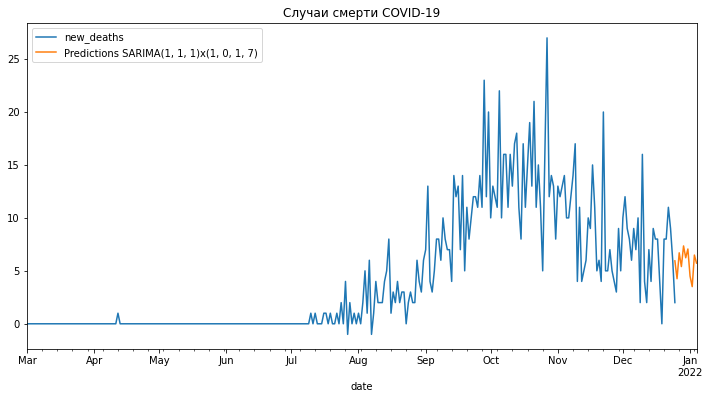

In [43]:
dax = df_a2['new_deaths'].plot(legend=True, figsize=(12,6),title='Случаи смерти COVID-19') 
fut_fcast_sarimax.plot(legend=True)

Модель сгладила пики и продолжила 

##PROPHET

In [44]:
# Разделяем наш датасет на тренировочную и тестовую выборки и переименуем колонки, что бы  использовать Prophet
train_prophet = train[['date','new_deaths']]
test_prophet = test[['date','new_deaths']]
train_prophet.columns = ['ds', 'y'] 
test_prophet.columns = ['ds', 'y']

In [45]:
# Внесем изменения в отношении всего датасета
df_a2_prophet = df_a2[['date','new_deaths']]
df_a2_prophet.columns = ['ds', 'y']

In [46]:
#Создаем и обучаем модель на обучающей выборке
model_prophet = Prophet(seasonality_mode='multiplicative') 
model_prophet.fit(train_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Модель определила, что есть недельная сезонность

In [47]:
#Прогнозируем на 10 дней
future_prophet = model_prophet.make_future_dataframe(periods=10)

In [48]:
predictions_prophet = model_prophet.predict(future_prophet)
predictions_prophet.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2021-03-01,-0.455213,-4.012109,3.483842,-0.455213,-0.455213,-0.019658,-0.019658,-0.019658,-0.019658,-0.019658,-0.019658,0.0,0.0,0.0,-0.446264
1,2021-03-02,-0.449717,-4.055254,3.303151,-0.449717,-0.449717,0.182648,0.182648,0.182648,0.182648,0.182648,0.182648,0.0,0.0,0.0,-0.531858
2,2021-03-03,-0.444222,-4.111424,3.036745,-0.444222,-0.444222,0.101271,0.101271,0.101271,0.101271,0.101271,0.101271,0.0,0.0,0.0,-0.489209
3,2021-03-04,-0.438726,-4.122169,2.947972,-0.438726,-0.438726,0.158356,0.158356,0.158356,0.158356,0.158356,0.158356,0.0,0.0,0.0,-0.508201
4,2021-03-05,-0.433231,-3.833454,3.323560,-0.433231,-0.433231,-0.126445,-0.126445,-0.126445,-0.126445,-0.126445,-0.126445,0.0,0.0,0.0,-0.378451


In [49]:
# Индексируем данные
predictions_prophet.index = predictions_prophet.ds
predictions_prophet.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
ds,,,,,,,,,,,,,,,,
2021-03-01,2021-03-01,-0.455213,-4.012109,3.483842,-0.455213,-0.455213,-0.019658,-0.019658,-0.019658,-0.019658,-0.019658,-0.019658,0.0,0.0,0.0,-0.446264
2021-03-02,2021-03-02,-0.449717,-4.055254,3.303151,-0.449717,-0.449717,0.182648,0.182648,0.182648,0.182648,0.182648,0.182648,0.0,0.0,0.0,-0.531858
2021-03-03,2021-03-03,-0.444222,-4.111424,3.036745,-0.444222,-0.444222,0.101271,0.101271,0.101271,0.101271,0.101271,0.101271,0.0,0.0,0.0,-0.489209
2021-03-04,2021-03-04,-0.438726,-4.122169,2.947972,-0.438726,-0.438726,0.158356,0.158356,0.158356,0.158356,0.158356,0.158356,0.0,0.0,0.0,-0.508201
2021-03-05,2021-03-05,-0.433231,-3.833454,3.323560,-0.433231,-0.433231,-0.126445,-0.126445,-0.126445,-0.126445,-0.126445,-0.126445,0.0,0.0,0.0,-0.378451


In [50]:
# оставляем необходимые данные
predictions_prophet[['ds', 'yhat']]

,ds,yhat
ds,,
2021-03-01,2021-03-01,-0.446264
2021-03-02,2021-03-02,-0.531858
2021-03-03,2021-03-03,-0.489209
2021-03-04,2021-03-04,-0.508201
2021-03-05,2021-03-05,-0.378451
...,...,...
2021-12-21,2021-12-21,9.227125
2021-12-22,2021-12-22,8.527555
2021-12-23,2021-12-23,8.901575


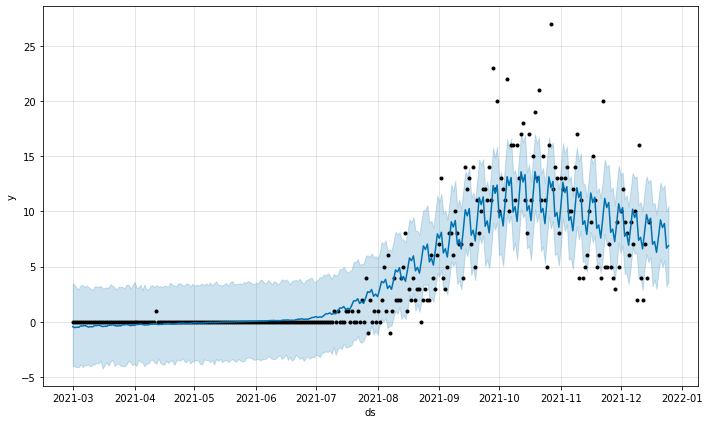

In [51]:
# Визуализируем прогнозируемые и известные начения
model_prophet.plot(predictions_prophet);

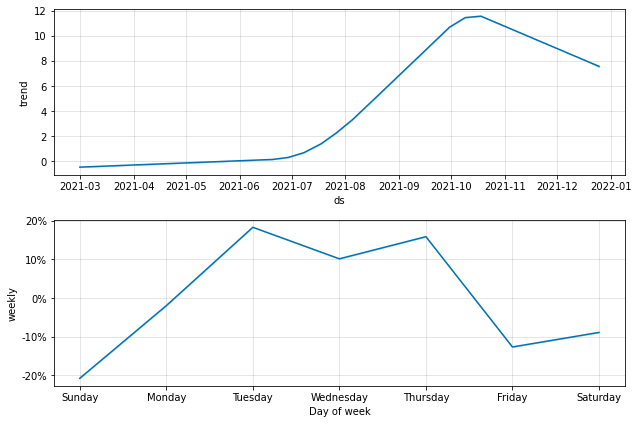

In [52]:
model_prophet.plot_components(predictions_prophet);

In [86]:
# Оцениваем качество модели
mse_error = mean_squared_error(test_prophet['y'], predictions_prophet['yhat'].tail(10))
rmse_error = rmse(test_prophet['y'], predictions_prophet['yhat'].tail(10))

print(f'Prophet MSE Error: {mse_error:11.10}')
print(f'Prophet RMSE Error: {rmse_error:11.10}')



Prophet MSE Error: 8.506515422
Prophet RMSE Error: 2.916593119


In [54]:
# Обучаем модель на полном датасете и создаем датасет на 10 дней вперед
fut_model_prophet = Prophet(seasonality_mode='multiplicative')
fut_model_prophet.fit(df_a2_prophet)


fut_future_prophet = fut_model_prophet.make_future_dataframe(periods=10)
fut_fcast_prophet = fut_model_prophet.predict(fut_future_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


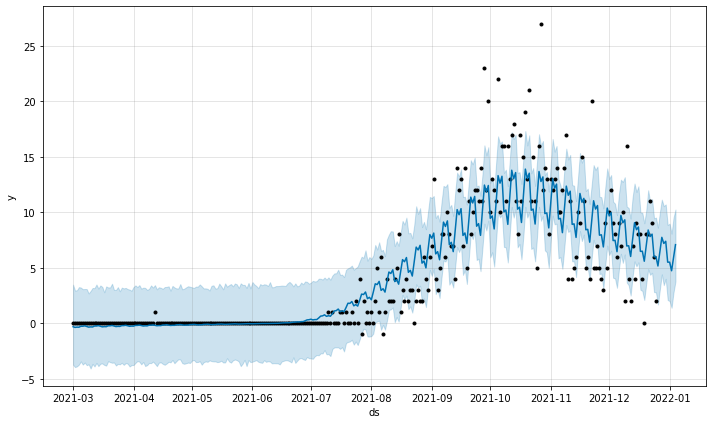

In [55]:
fut_model_prophet.plot(fut_fcast_prophet);

In [56]:
fut_fcast_prophet.index = fut_fcast_prophet.ds

In [57]:
fut_fcast_prophet.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
ds,,,,,,,,,,,,,,,,
2021-03-01,2021-03-01,-0.315294,-3.745571,3.484390,-0.315294,-0.315294,-0.016994,-0.016994,-0.016994,-0.016994,-0.016994,-0.016994,0.0,0.0,0.0,-0.309936
2021-03-02,2021-03-02,-0.312301,-3.948413,2.947295,-0.312301,-0.312301,0.190395,0.190395,0.190395,0.190395,0.190395,0.190395,0.0,0.0,0.0,-0.371762
2021-03-03,2021-03-03,-0.309308,-3.881693,2.975278,-0.309308,-0.309308,0.119454,0.119454,0.119454,0.119454,0.119454,0.119454,0.0,0.0,0.0,-0.346256
2021-03-04,2021-03-04,-0.306315,-3.724884,3.259498,-0.306315,-0.306315,0.164057,0.164057,0.164057,0.164057,0.164057,0.164057,0.0,0.0,0.0,-0.356569
2021-03-05,2021-03-05,-0.303322,-3.439107,3.217802,-0.303322,-0.303322,-0.121502,-0.121502,-0.121502,-0.121502,-0.121502,-0.121502,0.0,0.0,0.0,-0.266468


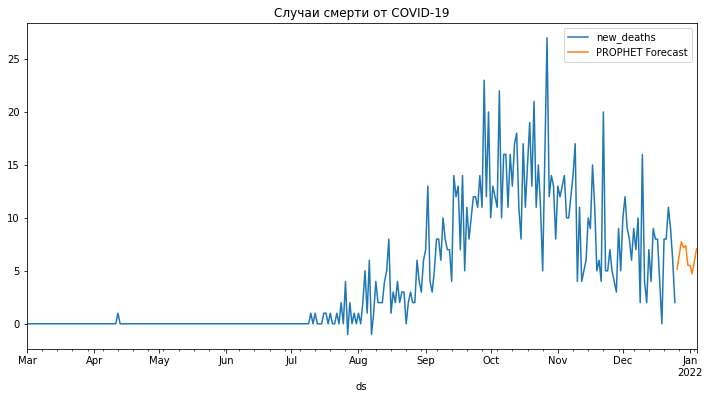

In [58]:
ax = df_a2_prophet['y'].plot(legend=True, figsize=(12,6),title='Случаи смерти от COVID-19') 
fut_fcast_prophet['yhat'].tail(10).plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.legend(["new_deaths", "PROPHET Forecast"]);

##Экспоненциальное сглаживание

In [59]:
model_exps = ExponentialSmoothing(train['new_deaths'], seasonal_periods=7, trend = 'add')


model_exps.fit()

In [60]:
model_exps.params

{'damping_trend': nan,
 'initial_level': -0.007848640698146843,
 'initial_seasons': array([], dtype=float64),
 'initial_trend': -0.00017450552857027396,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 0.1153029424208875,
 'smoothing_seasonal': nan,
 'smoothing_trend': 0.1153029424200018,
 'use_boxcox': False}

In [61]:
prediction_exps = model_exps.predict(model_exps.params, start=test.index[0], end=test.index[-1])

In [62]:
test.index[0]

Timestamp('2021-12-16 00:00:00')

In [63]:
test.index[-1]

Timestamp('2021-12-25 00:00:00')

In [64]:
prediction_exps

array([6.58282557, 6.56434404, 6.5458625 , 6.52738096, 6.50889942,
       6.49041788, 6.47193635, 6.45345481, 6.43497327, 6.41649173])

In [65]:
prediction_exps = pd.DataFrame(prediction_exps)
prediction_exps.index = pd.date_range("2021-12-10 00:00:00", periods=10, freq="D")

prediction_exps.columns = ['prediction_exps']

In [66]:
prediction_exps.head(10)

,prediction_exps
2021-12-10,6.582826
2021-12-11,6.564344
2021-12-12,6.545862
2021-12-13,6.527381
2021-12-14,6.508899
2021-12-15,6.490418
2021-12-16,6.471936
2021-12-17,6.453455
2021-12-18,6.434973
2021-12-19,6.416492


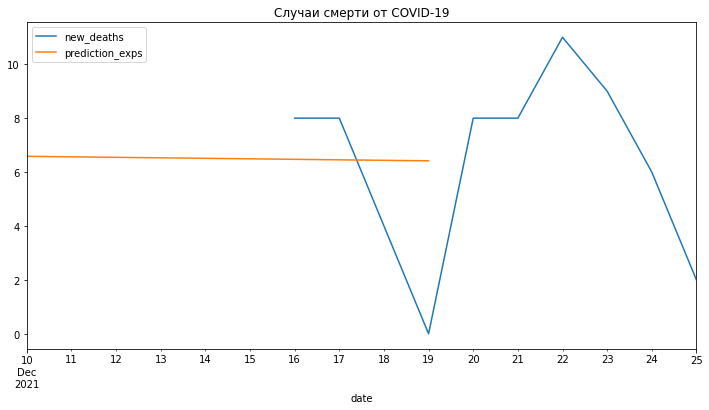

In [67]:
ax = test['new_deaths'].plot(legend=True, figsize=(12,6),title='Случаи смерти от COVID-19')
prediction_exps['prediction_exps'].plot(legend=True)
ax.autoscale(axis='x',tight=True)

Оценим качество модели с помощью MSE и RMSE

In [87]:

mse_error = mean_squared_error(test['new_deaths'], prediction_exps['prediction_exps'].tail(10))
rmse_error = rmse(test['new_deaths'], prediction_exps['prediction_exps'].tail(10))

print(f'MSE Error: {mse_error:11.10}')
print(f'RMSE Error: {rmse_error:11.10}')

MSE Error: 10.43426824
RMSE Error: 3.230211795


In [68]:
fut_model_exps = ExponentialSmoothing(df_a2['new_deaths'], seasonal_periods=7, trend = 'add')
fut_model_exps.fit()


fut_fcast_exps = fut_model_exps.predict(fut_model_exps.params, start=len(df_a2)-1, end=len(df_a2)+9)

fut_fcast_exps = pd.DataFrame(fut_fcast_exps)
fut_fcast_exps.index = pd.date_range("2021-12-24", periods=11, freq="D")
fut_fcast_exps.columns = ['fut_fcast_exps']

In [69]:
fut_fcast_exps.head()

,fut_fcast_exps
2021-12-24,6.883372
2021-12-25,6.298073
2021-12-26,6.268821
2021-12-27,6.239570
2021-12-28,6.210318


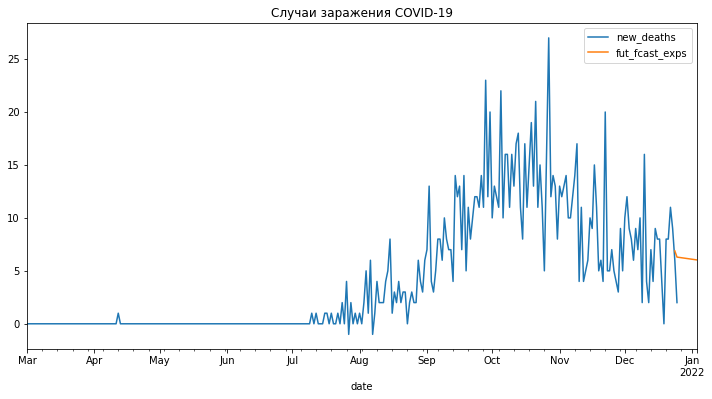

In [70]:
ax = df_a2['new_deaths'].plot(legend=True, figsize=(12,6),title='Случаи заражения COVID-19') 
fut_fcast_exps['fut_fcast_exps'].plot(legend=True)
ax.autoscale(axis='x',tight=True)

##Прогнозирование с помощью модели Хольта-Винтерса


In [71]:
model_holt = ExponentialSmoothing(train['new_deaths'], trend='add', seasonal = 'add', seasonal_periods=7).fit()
print(model_holt.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:               new_deaths   No. Observations:                  290
Model:             ExponentialSmoothing   SSE                           2035.165
Optimized:                         True   AIC                            587.051
Trend:                         Additive   BIC                            627.420
Seasonal:                      Additive   AICC                           588.370
Seasonal Periods:                     7   Date:                 Sun, 26 Dec 2021
Box-Cox:                          False   Time:                         10:26:18
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1163477                alpha                 True
smoothing_trend          

In [72]:
start=len(train)
end=len(train)+len(test)-1
predictions_holt = model_holt.predict(start=start, end=end).rename('Holt-Winters')

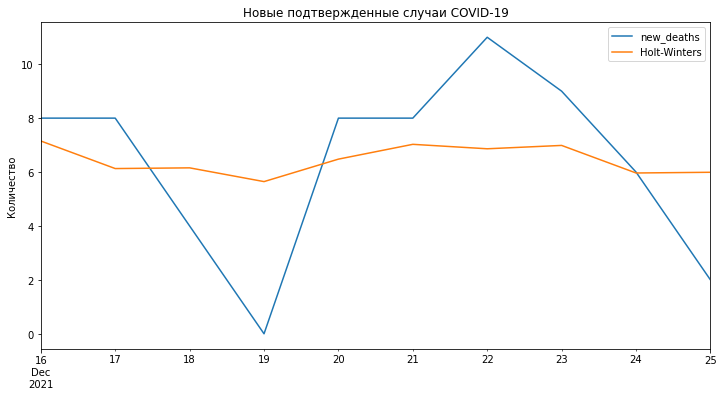

In [73]:
test['new_deaths'].plot(title = 'Новые подтвержденные случаи COVID-19', xlabel = '', ylabel = 'Количество', legend=True,  figsize=(12,6))
predictions_holt.plot(legend=True);

Оценим качество модели с помощью MSE и RMSE

In [74]:
error1 = mean_squared_error(test['new_deaths'], predictions_holt)
error2 = rmse(test['new_deaths'], predictions_holt)
print(f'Holt-Winters MSE Error: {error1:11.10}')
print(f'Holt-Winters RMSE Error: {error2:11.10}')

Holt-Winters MSE Error: 8.109132428
Holt-Winters RMSE Error: 2.847653846


In [75]:
fut_model_holt = ExponentialSmoothing(df_a2['new_deaths'], trend='add', seasonal = 'add', seasonal_periods=7).fit()

In [76]:
fut_predictions_holt = fut_model_holt.predict(len(df_a2)-1,len(df_a2)+9).rename('Holt-Winters')

In [77]:
print(fut_model_holt.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:               new_deaths   No. Observations:                  300
Model:             ExponentialSmoothing   SSE                           2132.499
Optimized:                         True   AIC                            610.380
Trend:                         Additive   BIC                            651.122
Seasonal:                      Additive   AICC                           611.653
Seasonal Periods:                     7   Date:                 Sun, 26 Dec 2021
Box-Cox:                          False   Time:                         10:26:19
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1102374                alpha                 True
smoothing_trend          

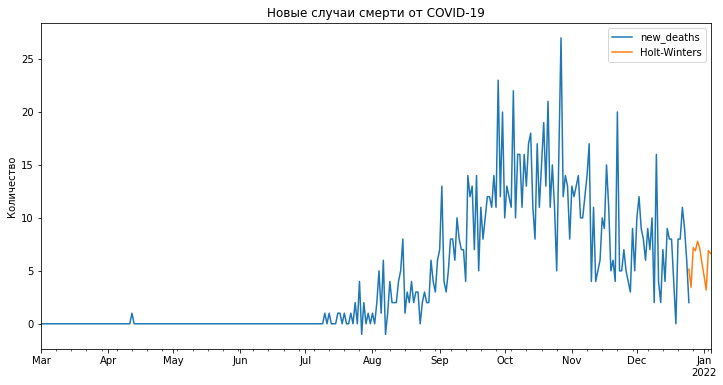

In [78]:
df_a2['new_deaths'].plot(title = 'Новые случаи смерти от COVID-19', xlabel = '', ylabel = 'Количество', legend=True,  figsize=(12,6))
fut_predictions_holt.plot(legend=True);

## Сравнение результатов использвания прогнозных моделей

Модель PROTHET

 MSE = 8,5 
 
 RMSE = 2.9

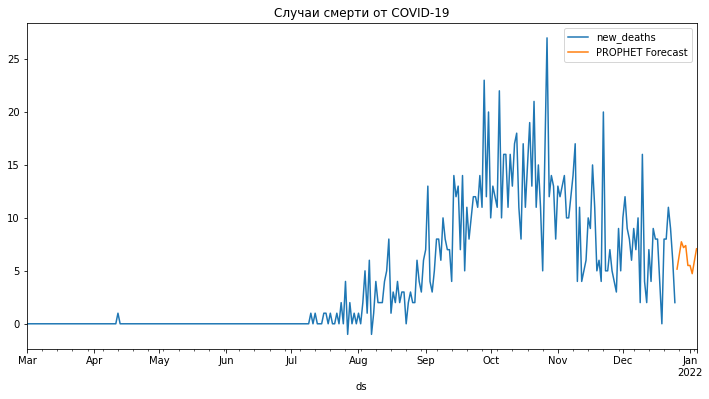

Модель SARIMA

MSE = 8.0

RMSE = 2.8

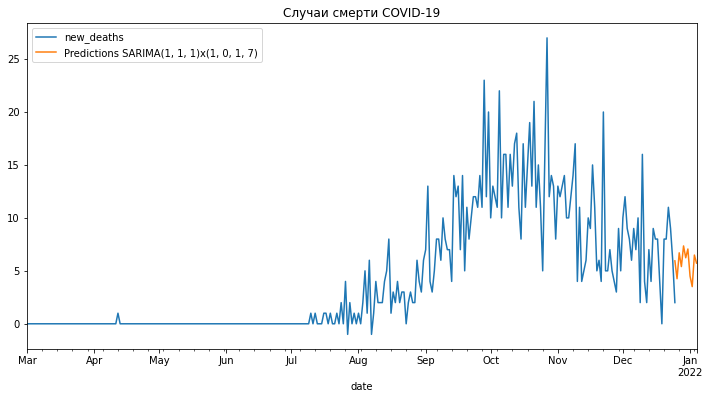

Модель "Экспоненциальное сглаживание"

MSE = 10.4
RMSE = 3.2

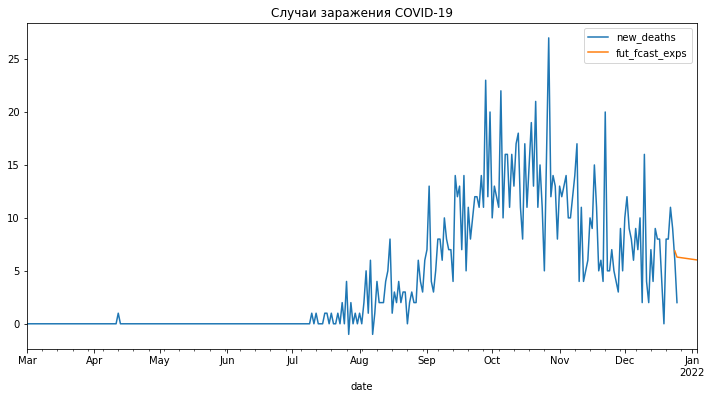

Модель Хольта-Винтерса

  MSE = 8.1

  RMSE = 2.8

  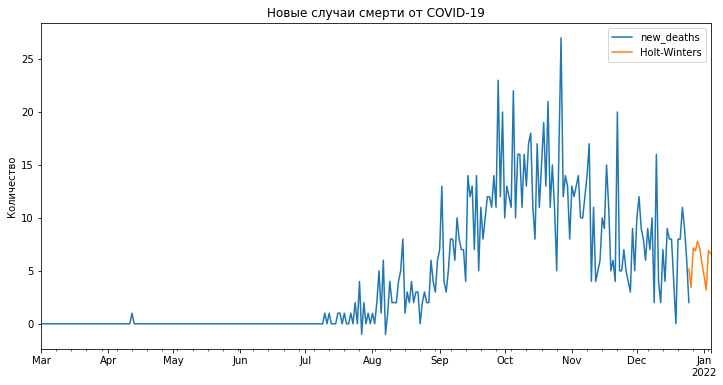